# MSDS 422 Assignment 9: Autoencoder

## Name: Tia Braimah
## Date: 05/30/2021

Thanks to the following sources whose's materials I used for this project

https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch17.html

Most of the code used are from Chapter 17 solution codes

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow.keras.layers
import tensorflow.keras.models
import tensorflow.keras.optimizers
import tensorflow.keras.datasets

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score


tensorflow.keras.backend.clear_session()
np.random.seed(42)
tensorflow.random.set_seed(42)


### Load Data

In [3]:
#train = pd.read_csv('input/Kannada-MNIST/train.csv')
#test = pd.read_csv('input/Kannada-MNIST/test.csv')
train = pd.read_csv('train_X.csv')
train_y = pd.read_csv('train_y.csv')
test = pd.read_csv('test_X.csv')

In [45]:
test_y = pd.read_csv('test_y.csv')

In [4]:
train.head()

,checking_status0_X_200,checking_status_200,checking_statusno_checking,duration,credit_historyall_paid,credit_historyexisting_paid,credit_historydelayed_previously,credit_historycritical_other_existing_credit,purposeused_car,purposefurniture_equipment,...,other_payment_plansstores,other_payment_plansnone,housingown,housingforfree,existing_credits,jobunskilled_resident,jobskilled,jobhigh_qualif_self_emp_mgmt,num_dependents,own_telephoneyes
0,0,0,0,0.029412,0,0,0,1,0,0,...,0,1,1,0,0.333333,0,1,0,0,1
1,0,0,0,0.029412,0,0,0,1,0,0,...,0,1,1,0,0.333333,0,1,0,0,1
2,0,0,0,0.029412,0,0,0,1,0,0,...,0,1,1,0,0.333333,0,1,0,0,1
3,0,0,0,0.029412,0,0,0,1,0,0,...,0,1,1,0,0.333333,0,1,0,0,1
4,0,0,0,0.029412,0,0,0,1,0,0,...,0,1,1,0,0.333333,0,1,0,0,1


In [5]:
test.head()

,checking_status0_X_200,checking_status_200,checking_statusno_checking,duration,credit_historyall_paid,credit_historyexisting_paid,credit_historydelayed_previously,credit_historycritical_other_existing_credit,purposeused_car,purposefurniture_equipment,...,other_payment_plansstores,other_payment_plansnone,housingown,housingforfree,existing_credits,jobunskilled_resident,jobskilled,jobhigh_qualif_self_emp_mgmt,num_dependents,own_telephoneyes
0,0,0,0,0.029412,0,0,0,1,0,0,...,0,1,1,0,0.333333,0,1,0,0,1
1,0,0,0,0.029412,0,0,0,1,0,0,...,0,1,1,0,0.333333,0,1,0,0,1
2,0,0,0,0.029412,0,0,0,1,0,0,...,0,1,1,0,0.333333,0,1,0,0,1
3,0,0,0,0.029412,0,0,0,1,0,0,...,0,1,1,0,0.333333,0,1,0,0,1
4,0,0,0,0.029412,0,0,0,1,0,0,...,0,1,1,0,0.333333,0,1,0,0,1


In [8]:
X_train, X_valid = X_train_full[:-18000], X_train_full[-18000:]
y_train, y_valid = y_train_full[:-18000], y_train_full[-18000:]
dfy_train, dfy_valid = dfy[:-18000], dfy[-18000:]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, dfy_train.shape, dfy_valid.shape

((42000, 28, 28, 1),
 (18000, 28, 28, 1),
 (42000, 10),
 (18000, 10),
 (42000, 1),
 (18000, 1))

# Method 1: Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [6]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [21]:
#import keras
#from keras import layers

# This is the size of our encoded representations
encoding_dim = 25  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

input_img = keras.Input(shape =  (44,))
# "encoded" is the encoded representation of the input
encoded = keras.layers.Dense(encoding_dim, activation='relu')(input_img)

encoder = keras.Model(input_img, encoded)
# "decoded" is the lossy reconstruction of the input
decoded = keras.layers.Dense(44, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)


In [22]:
# This is our encoded (32-dimensional) input
#encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
# Create the decoder model
#decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [23]:
tensorflow.random.set_seed(42)
np.random.seed(42)
import tensorflow as tf


history = autoencoder.fit(train, train, epochs=20,validation_data=(test, test))

Epoch 1/20
25000/25000 [==============================] - 28s 1ms/step - loss: 0.0699 - val_loss: 0.0557
Epoch 2/20
25000/25000 [==============================] - 29s 1ms/step - loss: 0.0556 - val_loss: 0.0554
Epoch 3/20
25000/25000 [==============================] - 30s 1ms/step - loss: 0.0554 - val_loss: 0.0553
Epoch 4/20
25000/25000 [==============================] - 29s 1ms/step - loss: 0.0554 - val_loss: 0.0553
Epoch 5/20
25000/25000 [==============================] - 29s 1ms/step - loss: 0.0553 - val_loss: 0.0553
Epoch 6/20
25000/25000 [==============================] - 28s 1ms/step - loss: 0.0553 - val_loss: 0.0553
Epoch 7/20
25000/25000 [==============================] - 27s 1ms/step - loss: 0.0553 - val_loss: 0.0553
Epoch 8/20
25000/25000 [==============================] - 26s 1ms/step - loss: 0.0553 - val_loss: 0.0553
Epoch 9/20
25000/25000 [==============================] - 25s 1ms/step - loss: 0.0553 - val_loss: 0.0553
Epoch 10/20
25000/25000 [==============================

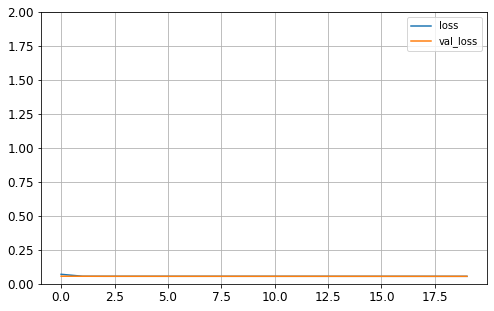

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

### Visualizing Kannada-MNIST Before and After Encoding/Decoding

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = autoencoder.predict(test)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

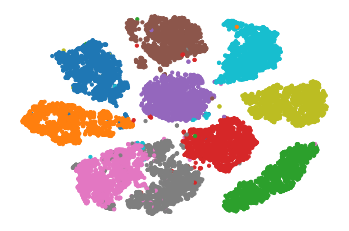

In [15]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=dfy_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

# Prediction using Encoded images

In [28]:
ae_train = autoencoder.predict(train)
ae_test = autoencoder.predict(test)

### Using RandomForest Classifier

In [34]:
nx, ny = ae_train.shape
nx, ny

(800000, 44)

In [35]:
nx, ny = ae_test.shape
nx, ny

(200000, 44)

In [38]:
ae_train2.shape

(35200000,)

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_features = 'sqrt', n_estimators=10, bootstrap=True, random_state=42)

nx, ny = ae_train.shape
ae_train2 = ae_train.reshape((nx*ny))

#dfy = dfy.reshape(nsamples)


nx, ny = ae_test.shape
ae_test2 = ae_test.reshape((nx*ny))



rf_clf.fit(ae_train2,train_y)
y_test = rf_clf.predict(ae_test2)

In [17]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_features = 'sqrt', n_estimators=10, bootstrap=True, random_state=42)

nsamples, nx, ny = ae_train.shape
ae_train2 = ae_train.reshape((nsamples,nx*ny))

dfy = dfy.reshape(nsamples)


nsamples, nx, ny = ae_test.shape
ae_test2 = ae_test.reshape((nsamples,nx*ny))



rf_clf.fit(ae_train2,dfy)
y_test = rf_clf.predict(ae_test2)

Wall time: 21.5 s


In [18]:
# Read in sample_submission dataframe
submission = pd.read_csv("input/Kannada-MNIST/sample_submission.csv")

In [19]:
submission=pd.DataFrame({"id": list(range(0,len(y_test))),"label": y_test})
#submission.to_csv("submission.csv", index=False, header=True)

In [20]:
submission.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


In [56]:
train_y['x'] = pd.get_dummies(train_y['x'], drop_first=True)

In [57]:

from sklearn.linear_model import LogisticRegression


log_model = LogisticRegression(penalty = "l2", solver = "lbfgs", C=1.5,fit_intercept = True, max_iter=1500, 
                               multi_class ='auto', warm_start = True)
log_model.fit(ae_train, train_y)
print("Training Set Score: {:.3f}".format(log_model.score(ae_train, train_y)*100))



C:\Users\nbinw\anaconda3\envs\tf2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training Set Score: 70.000


In [58]:
train_y.head()

,x
0,1
1,0
2,1
3,1
4,0


In [53]:

test_y['V1'] = pd.get_dummies(test_y['V1'], drop_first=True)


In [59]:
from sklearn.metrics import roc_auc_score


predictions = log_model.predict(ae_test)
print("Train_Test Set Score: {:.3f}".format(log_model.score(ae_test, test_y)*100))
acc_log = round(roc_auc_score(test_y, predictions)*100 , 2)
acc_log

Train_Test Set Score: 70.000


50.0

In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(test_y, predictions, normalize=False)
from sklearn.metrics import confusion_matrix


print(classification_report(test_y,predictions))
print(confusion_matrix(test_y,predictions))


ModuleNotFoundError: No module named 'scikitplot'

Text(0.5, 1.0, 'Precision-Recall')

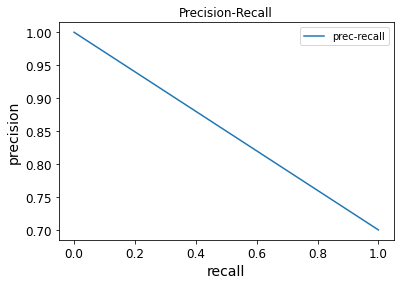

In [67]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(test_y, predictions)
plt.plot(recalls, precisions, label = 'prec-recall')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(loc="upper right")
plt.title("Precision-Recall")


### Using Neural Networks

In [21]:
# Define the loss function Going to Lock this Loss Function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model1 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=[28, 28]),
  tf.keras.layers.Dense(500, activation='relu'),
  #tf.keras.layers.Dropout(0.2),
  #  tf.keras.layers.Dense(500, activation='relu'),
  tf.keras.layers.Dense(350, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  # I don't know what this does...
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation="softmax")
])


In [22]:
# How do we optomize the loss function and what do we measure
model1.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [23]:
history = model1.fit(ae_train2, dfy, epochs=20, validation_data=(X_valid, dfy_valid))

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5201 - accuracy: 0.9440 - val_loss: 1.5008 - val_accuracy: 0.9605
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5012 - accuracy: 0.9597 - val_loss: 1.4804 - val_accuracy: 0.9807
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4972 - accuracy: 0.9639 - val_loss: 1.4805 - val_accuracy: 0.9806
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4970 - accuracy: 0.9640 - val_loss: 1.4855 - val_accuracy: 0.9756
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4961 - accuracy: 0.9649 - val_loss: 1.4781 - val_accuracy: 0.9829
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4950 - accuracy: 0.9661 - val_loss: 1.4785 - val_accuracy: 0.9827
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4957 - accuracy: 0.9653 - val_loss: 1.4819 - val_accuracy:

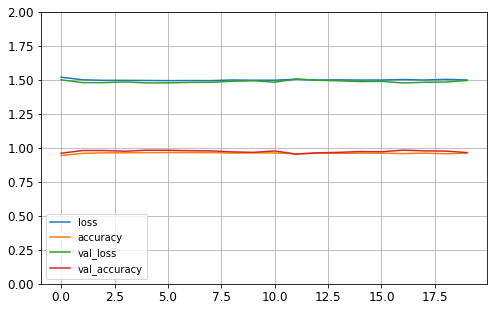

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

### Submission

In [25]:
y_test = model1.predict(ae_test2)

# Read in sample_submission dataframe
submission = pd.read_csv("input/Kannada-MNIST/sample_submission.csv")

# Append predictions from blended models
submission.iloc[:,1] = np.argmax(model1.predict(ae_test2), axis=-1)
#submission.to_csv("submission.csv", index=False)

submission.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


# Method 2: Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [26]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [27]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=30,
                      validation_data=(X_valid, X_valid))

Epoch 1/30
1313/1313 [==============================] - 3s 3ms/step - loss: 0.1653 - rounded_accuracy: 0.9275 - val_loss: 0.1330 - val_rounded_accuracy: 0.9420: 1s - los - ETA: 0s - l
Epoch 2/30
1313/1313 [==============================] - 3s 2ms/step - loss: 0.1238 - rounded_accuracy: 0.9476 - val_loss: 0.1193 - val_rounded_accuracy: 0.9500: 1s - loss: 0.1288 - rounded_accu
Epoch 3/30
1313/1313 [==============================] - 3s 3ms/step - loss: 0.1144 - rounded_accuracy: 0.9530 - val_loss: 0.1122 - val_rounded_accuracy: 0.9543
Epoch 4/30
1313/1313 [==============================] - 4s 3ms/step - loss: 0.1092 - rounded_accuracy: 0.9561 - val_loss: 0.1088 - val_rounded_accuracy: 0.9565
Epoch 5/30
1313/1313 [==============================] - 3s 2ms/step - loss: 0.1066 - rounded_accuracy: 0.9576 - val_loss: 0.1074 - val_rounded_accuracy: 0.9568
Epoch 6/30
1313/1313 [==============================] - 3s 2ms/step - loss: 0.1052 - rounded_accuracy: 0.9584 - val_loss: 0.1056 - val_rounded

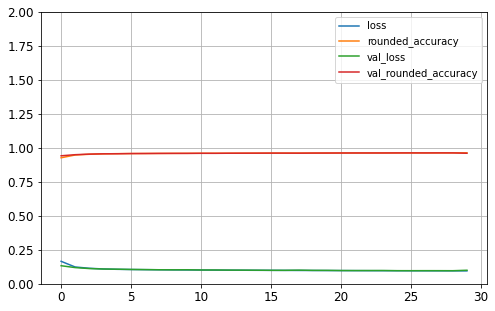

In [28]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

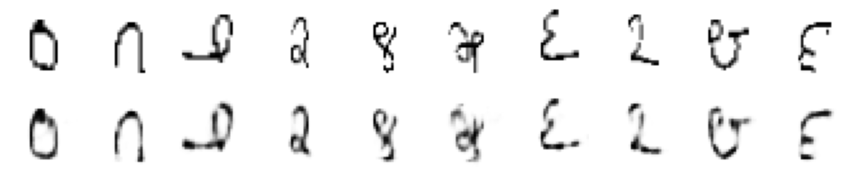

In [29]:
show_reconstructions(tied_ae)
plt.show()

## Prediction using Encoded images

In [30]:
ae_train = tied_ae.predict(X_train_full)
ae_test = tied_ae.predict(X_test)

### Using RandomForest Classifier

In [31]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_features = 'sqrt', n_estimators=10, bootstrap=True, random_state=42)

nsamples, nx, ny = ae_train.shape
ae_train2 = ae_train.reshape((nsamples,nx*ny))

dfy = dfy.reshape(nsamples)


nsamples, nx, ny = ae_test.shape
ae_test2 = ae_test.reshape((nsamples,nx*ny))



rf_clf.fit(ae_train2,dfy)
y_test = rf_clf.predict(ae_test2)

Wall time: 19.1 s


## Submission

In [32]:
# Read in sample_submission dataframe
submission = pd.read_csv("input/Kannada-MNIST/sample_submission.csv")

In [33]:
submission=pd.DataFrame({"id": list(range(0,len(y_test))), "label": y_test})
#submission.to_csv("submission.csv", index=False, header=True)

In [34]:
submission.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


### Using Neural Networks

In [35]:
# Define the loss function Going to Lock this Loss Function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=[28, 28]),
  tf.keras.layers.Dense(500, activation='relu'),
  tf.keras.layers.Dense(350, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(10, activation="softmax")
])

In [36]:
# How do we optomize the loss function and what do we measure
model2.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])


history = model2.fit(ae_train2, dfy, epochs=20, validation_data=(X_valid, dfy_valid))

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5298 - accuracy: 0.9339 - val_loss: 1.4890 - val_accuracy: 0.9724
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 1.4959 - accuracy: 0.9652 - val_loss: 1.4786 - val_accuracy: 0.9825
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4919 - accuracy: 0.9690 - val_loss: 1.4818 - val_accuracy: 0.9792
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 1.4926 - accuracy: 0.9686 - val_loss: 1.4833 - val_accuracy: 0.9778
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4911 - accuracy: 0.9699 - val_loss: 1.4766 - val_accuracy: 0.9846
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4924 - accuracy: 0.9687 - val_loss: 1.4808 - val_accuracy: 0.9802
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4948 - accuracy: 0.9663 - val_loss: 1.4807 - val_accuracy:

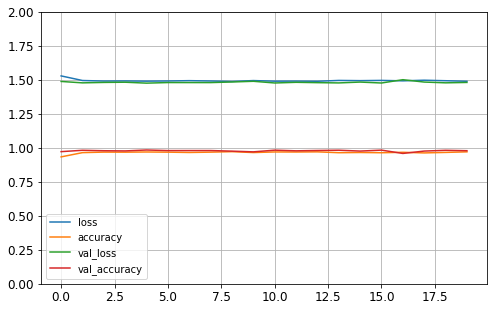

In [37]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

### Submission

In [38]:
y_test = model2.predict(ae_test2)

# Read in sample_submission dataframe
submission = pd.read_csv("input/Kannada-MNIST/sample_submission.csv")

# Append predictions from blended models
submission.iloc[:,1] = np.argmax(y_test, axis=-1)
#submission.to_csv("submission.csv", index=False)

submission.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


# Method 3: Using Convolutional Layers Instead of Dense Layers

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [39]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1313/1313 [==============================] - 20s 15ms/step - loss: 0.1269 - rounded_accuracy: 0.9478 - val_loss: 0.1005 - val_rounded_accuracy: 0.9598
Epoch 2/5
1313/1313 [==============================] - 20s 15ms/step - loss: 0.0927 - rounded_accuracy: 0.9651 - val_loss: 0.0882 - val_rounded_accuracy: 0.9684
Epoch 3/5
1313/1313 [==============================] - 20s 15ms/step - loss: 0.0855 - rounded_accuracy: 0.9700 - val_loss: 0.0827 - val_rounded_accuracy: 0.9721
Epoch 4/5
1313/1313 [==============================] - 19s 15ms/step - loss: 0.0814 - rounded_accuracy: 0.9727 - val_loss: 0.0818 - val_rounded_accuracy: 0.9724
Epoch 5/5
1313/1313 [==============================] - 19s 15ms/step - loss: 0.0787 - rounded_accuracy: 0.9746 - val_loss: 0.0775 - val_rounded_accuracy: 0.9758


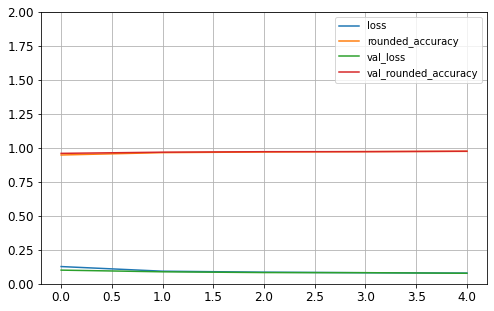

In [40]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [41]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)         

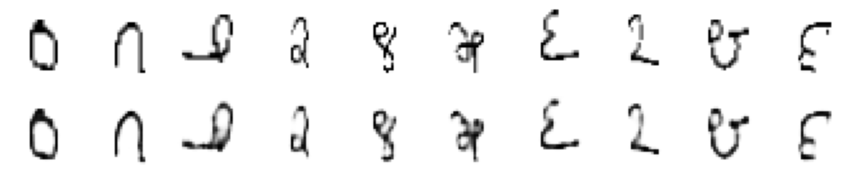

In [42]:
show_reconstructions(conv_ae)
plt.show()

## Prediction using Encoded images

In [43]:
ae_train = conv_ae.predict(X_train_full)
ae_test = conv_ae.predict(X_test)

In [44]:
nsamples, nx, ny = ae_train.shape
ae_train2 = ae_train.reshape((nsamples,nx*ny))

dfy = dfy.reshape(nsamples)


nsamples, nx, ny = ae_test.shape
ae_test2 = ae_test.reshape((nsamples,nx*ny))

#### Using Neural Networks

In [45]:
# Define the loss function Going to Lock this Loss Function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=[28, 28]),
  tf.keras.layers.Dense(500, activation='relu'),
  tf.keras.layers.Dense(350, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(10, activation="softmax")
])

In [46]:
# How do we optomize the loss function and what do we measure
model3.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

history = model3.fit(ae_train2, dfy, epochs=20, validation_data=(X_valid, dfy_valid))

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5249 - accuracy: 0.9383 - val_loss: 1.4856 - val_accuracy: 0.9758
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4957 - accuracy: 0.9656 - val_loss: 1.5029 - val_accuracy: 0.9583
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 1.4916 - accuracy: 0.9694 - val_loss: 1.4772 - val_accuracy: 0.9841
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4892 - accuracy: 0.9718 - val_loss: 1.4761 - val_accuracy: 0.9850
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4877 - accuracy: 0.9735 - val_loss: 1.4758 - val_accuracy: 0.9853
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 1.4862 - accuracy: 0.9750 - val_loss: 1.4773 - val_accuracy: 0.9837
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4882 - accuracy: 0.9728 - val_loss: 1.4789 - val_accuracy:

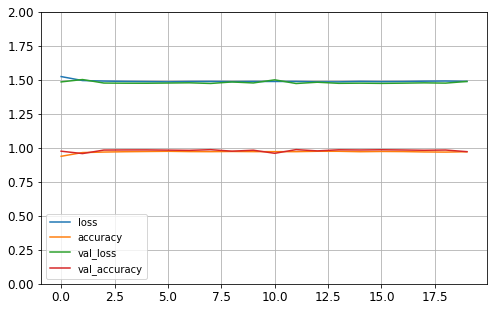

In [47]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [48]:
y_test = model3.predict(ae_test2)

# Read in sample_submission dataframe
submission = pd.read_csv("input/Kannada-MNIST/sample_submission.csv")

# Append predictions from blended models
submission.iloc[:,1] = np.argmax(y_test, axis=-1)
#submission.to_csv("submission.csv", index=False)

submission.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


# Method 4: Stacked denoising Autoencoder

Using Gaussian noise:

In [49]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=20,
                           validation_data=(X_valid, X_valid))

Epoch 1/20
1313/1313 [==============================] - 4s 3ms/step - loss: 0.1976 - rounded_accuracy: 0.9190 - val_loss: 0.1678 - val_rounded_accuracy: 0.9267
Epoch 2/20
1313/1313 [==============================] - 4s 3ms/step - loss: 0.1561 - rounded_accuracy: 0.9320 - val_loss: 0.1466 - val_rounded_accuracy: 0.9350 0.1572 - rounded_
Epoch 3/20
1313/1313 [==============================] - 4s 3ms/step - loss: 0.1435 - rounded_accuracy: 0.9372 - val_loss: 0.1381 - val_rounded_accuracy: 0.9390
Epoch 4/20
1313/1313 [==============================] - 3s 2ms/step - loss: 0.1374 - rounded_accuracy: 0.9400 - val_loss: 0.1328 - val_rounded_accuracy: 0.9421
Epoch 5/20
1313/1313 [==============================] - 3s 2ms/step - loss: 0.1333 - rounded_accuracy: 0.9422 - val_loss: 0.1285 - val_rounded_accuracy: 0.9443
Epoch 6/20
1313/1313 [==============================] - 3s 2ms/step - loss: 0.1300 - rounded_accuracy: 0.9439 - val_loss: 0.1256 - val_rounded_accuracy: 0.9460
Epoch 7/20
1313/1313 [

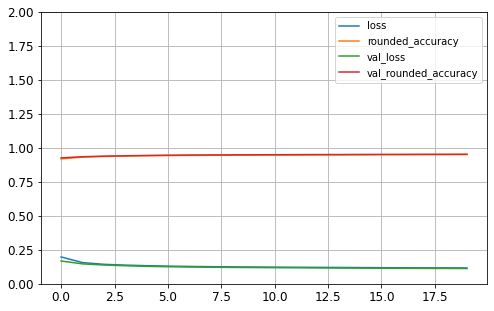

In [50]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



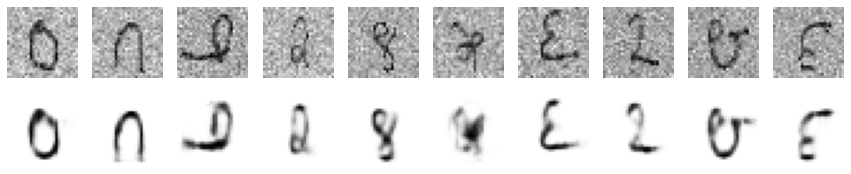

In [51]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

## Prediction using Encoded images

In [52]:
ae_train = denoising_ae.predict(X_train_full)
ae_test = denoising_ae.predict(X_test)

nsamples, nx, ny = ae_train.shape
ae_train2 = ae_train.reshape((nsamples,nx*ny))

dfy = dfy.reshape(nsamples)


nsamples, nx, ny = ae_test.shape
ae_test2 = ae_test.reshape((nsamples,nx*ny))

In [53]:
# Define the loss function Going to Lock this Loss Function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model4 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=[28, 28]),
  tf.keras.layers.Dense(500, activation='relu'),
  tf.keras.layers.Dense(350, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(10, activation="softmax")
])

In [54]:
# How do we optomize the loss function and what do we measure
model4.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

history = model4.fit(ae_train2, dfy, epochs=20, validation_data=(X_valid, dfy_valid))

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5235 - accuracy: 0.9398 - val_loss: 1.4860 - val_accuracy: 0.9754
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5051 - accuracy: 0.9560 - val_loss: 1.4969 - val_accuracy: 0.9642
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5060 - accuracy: 0.9550 - val_loss: 1.4838 - val_accuracy: 0.9772
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5042 - accuracy: 0.9569 - val_loss: 1.4878 - val_accuracy: 0.9734
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5043 - accuracy: 0.9567 - val_loss: 1.5133 - val_accuracy: 0.9474
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5054 - accuracy: 0.9556 - val_loss: 1.4992 - val_accuracy: 0.9617
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5038 - accuracy: 0.9573 - val_loss: 1.4992 - val_accuracy:

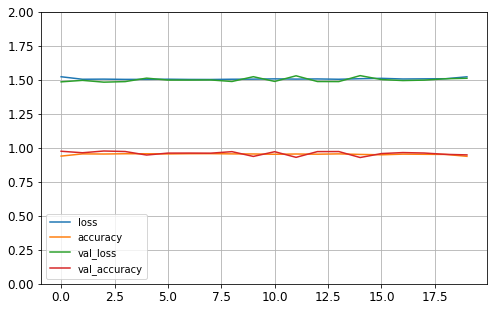

In [55]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [56]:
y_test = model4.predict(ae_test2)

# Read in sample_submission dataframe
submission = pd.read_csv("input/Kannada-MNIST/sample_submission.csv")

# Append predictions from blended models
submission.iloc[:,1] = np.argmax(y_test, axis=-1)
#submission.to_csv("submission.csv", index=False)

submission.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


# Method 5: Variational Autoencoder

In [57]:
K = keras.backend
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [58]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
329/329 [==============================] - 3s 8ms/step - loss: 0.2024 - rounded_accuracy: 0.9205 - val_loss: 0.1796 - val_rounded_accuracy: 0.9257
Epoch 2/25
329/329 [==============================] - 2s 7ms/step - loss: 0.1648 - rounded_accuracy: 0.9323 - val_loss: 0.1638 - val_rounded_accuracy: 0.9318
Epoch 3/25
329/329 [==============================] - 3s 8ms/step - loss: 0.1562 - rounded_accuracy: 0.9364 - val_loss: 0.1575 - val_rounded_accuracy: 0.9359
Epoch 4/25
329/329 [==============================] - 2s 6ms/step - loss: 0.1516 - rounded_accuracy: 0.9390 - val_loss: 0.1545 - val_rounded_accuracy: 0.9375
Epoch 5/25
329/329 [==============================] - 2s 7ms/step - loss: 0.1489 - rounded_accuracy: 0.9407 - val_loss: 0.1518 - val_rounded_accuracy: 0.9388
Epoch 6/25
329/329 [==============================] - 2s 7ms/step - loss: 0.1468 - rounded_accuracy: 0.9420 - val_loss: 0.1507 - val_rounded_accuracy: 0.9400
Epoch 7/25
329/329 [==============================] 

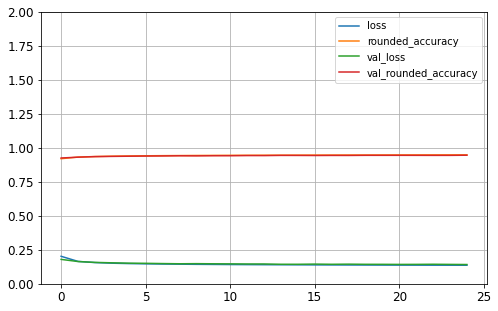

In [59]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

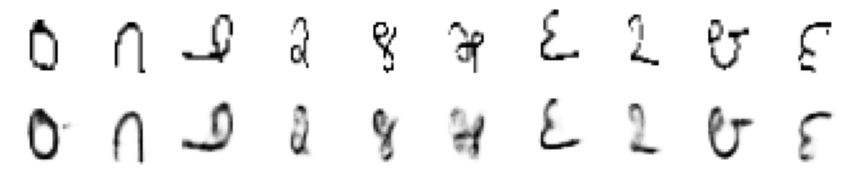

In [60]:
show_reconstructions(variational_ae)
plt.show()

## Prediction using Encoded images

In [61]:
ae_train = variational_ae.predict(X_train_full)
ae_test = variational_ae.predict(X_test)

nsamples, nx, ny = ae_train.shape
ae_train2 = ae_train.reshape((nsamples,nx*ny))

dfy = dfy.reshape(nsamples)


nsamples, nx, ny = ae_test.shape
ae_test2 = ae_test.reshape((nsamples,nx*ny))

In [62]:
# Define the loss function Going to Lock this Loss Function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model5 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=[28, 28]),
  tf.keras.layers.Dense(500, activation='relu'),
  tf.keras.layers.Dense(350, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(10, activation="softmax")
])


# How do we optomize the loss function and what do we measure
model5.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

history = model5.fit(ae_train2, dfy, epochs=20, validation_data=(X_valid, dfy_valid))

Epoch 1/20
1875/1875 [==============================] - 7s 4ms/step - loss: 1.5353 - accuracy: 0.9283 - val_loss: 1.5057 - val_accuracy: 0.9553
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5219 - accuracy: 0.9389 - val_loss: 1.5090 - val_accuracy: 0.9520
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5172 - accuracy: 0.9440 - val_loss: 1.5073 - val_accuracy: 0.9536
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5206 - accuracy: 0.9403 - val_loss: 1.5085 - val_accuracy: 0.9526
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 1.5203 - accuracy: 0.9408 - val_loss: 1.4983 - val_accuracy: 0.9628
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5200 - accuracy: 0.9411 - val_loss: 1.5063 - val_accuracy: 0.9548
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 1.5234 - accuracy: 0.9377 - val_loss: 1.5109 - val_accuracy:

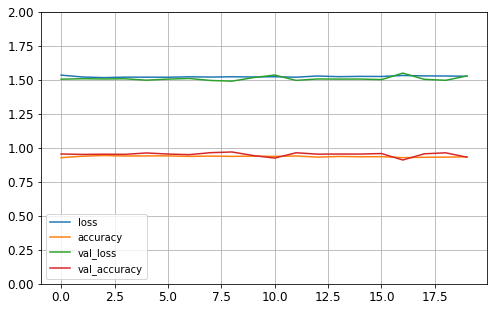

In [63]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

### Submission

In [64]:
y_test = model5.predict(ae_test2)

# Read in sample_submission dataframe
submission = pd.read_csv("input/Kannada-MNIST/sample_submission.csv")

# Append predictions from blended models
submission.iloc[:,1] = np.argmax(y_test, axis=-1)
submission.to_csv("submission.csv", index=False)

submission.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
